Using: cuda
Length of Train Data : 3000
Length of Validation Data : 513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


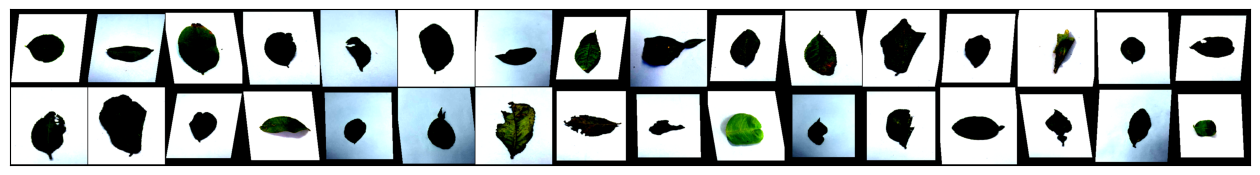

In [1]:
from datasetup import *

In [2]:
from resnet50 import *
from densenet121 import *
from efficientnetb0 import *
from mobilenetv2 import *

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are depreca

In [3]:
import copy
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset

In [4]:
def train_with_unfreeze(model, name, criterion, optimizer, dataloaders, num_epochs=10, patience=3, freeze_epochs=2):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0

    history = {"train_loss": [], "train_acc": [],
               "test_loss": [], "test_acc": [], "test_f1": []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # UNFREEZE after N epochs
        if epoch == freeze_epochs:
            print("Unfreezing backbone...")
            if name == "ResNet50":
                for layer in [model.conv1, model.bn1, model.layer1, model.layer2, model.layer3, model.layer4]:
                    for param in layer.parameters():
                        param.requires_grad = True
            else:
                for param in model.features.parameters():  # or model.backbone if different
                    param.requires_grad = True
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

        for phase in ["train", "test"]:
            model.train() if phase == "train" else model.eval()
            running_loss, running_corrects = 0.0, 0
            y_true, y_pred = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc.item())

            if phase == "test":
                f1 = f1_score(y_true, y_pred)
                history["test_f1"].append(f1)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= patience:
                    print("Early stopping.")
                    model.load_state_dict(best_model_wts)
                    return model, history, y_true, y_pred

            print(f"{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history, y_true, y_pred


In [5]:
def run_k_fold(model_fn,name, dataset, weights, k=5, freeze_epochs=2, num_epochs=10, patience=3):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    labels = [dataset.img_labels[i] for i in range(len(dataset))]

    all_f1_curves = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, labels)):
        print(f"\n======= Fold {fold+1}/{k} =======")

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        dataloaders_fold = {
            "train": torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True),
            "test": torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)
        }

        model = model_fn().to(device)
        criterion = nn.CrossEntropyLoss(weight=weights)
        if name == "ResNet50":
            optimizer = optimizer_res
        else: optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

        model, history, _, _ = train_with_unfreeze(
            model,name, criterion, optimizer, dataloaders_fold,
            num_epochs=num_epochs, patience=patience,
            freeze_epochs=freeze_epochs
        )

        all_f1_curves.append(history["test_f1"])

    return all_f1_curves


In [6]:
def plot_avg_f1_across_folds(model_name, all_f1_curves):
    avg_f1 = np.mean(np.array([np.pad(f, (0, max(map(len, all_f1_curves)) - len(f)), 'edge') for f in all_f1_curves]), axis=0)

    plt.plot(range(1, len(avg_f1)+1), avg_f1, label=model_name)
    plt.xlabel("Epoch"); plt.ylabel("Avg F1 Score")
    plt.title(f"F1 Curve Across Folds - {model_name}")
    plt.grid(True)
    plt.legend()
    plt.show()


In [7]:
models_info = [
    #("DenseNet121", lambda: copy.deepcopy(densenet_model)),
    #("MobileNetV2", lambda: copy.deepcopy(mobilenet_model)),
    #("EfficientNetB0", lambda: copy.deepcopy(efficientnet_model)),
    ("ResNet50", lambda: copy.deepcopy(resnet_model))
]

for name, model in models_info:
    print(f"\n=== Running K-Fold for {name} ===")
    all_f1_curves = run_k_fold(
        model_fn=model,
        name=name,
        dataset=dataset,
        weights=weights,
        k=5,
        num_epochs=10,
        freeze_epochs=2
    )
    plot_avg_f1_across_folds(name, all_f1_curves)



=== Running K-Fold for ResNet50 ===

======= Fold 1/5 =======

Epoch 1/10


RuntimeError: weight tensor should be defined either for all 2 classes or no classes but got weight tensor of shape: [14]